# XLM-RoBERTa Transfer Learning for Sentiment Analysis on Multilingual data
- goal : multi-class classification
- labels : `positive`, `negative`, `neutral`
- accelerator : TPU v3-8

#### XLM-R 
> [HuggingFace Multilingual Model](https://huggingface.co/docs/transformers/multilingual#xlmroberta)
> XLM-RoBERTa was trained on 2.5TB of newly created clean CommonCrawl data in 100 languages via masked language modeling MLM. 
> It provides strong gains over previously released multi-lingual models like mBERT or XLM on downstream tasks like classification, sequence labeling and question answering.

- why not `xlm-roberta-base` but `jplu/tf-xlm-roberta-base` ?
> Because the tensorflow version of model weights of `xlm-roberta-base` is deprecated. Plus, I decided to use Tensorflow Distribute due to its easier usage (Pytorch/XLA is recently having issues with wheels and image on Google Colab with TPUs). I found `jplu/tf-xlm-roberta-base` on HuggingFace model hub and then found this [kaggle notebook](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta#Submission) to be based on.

#### model building process :
Most processes are modularized into [functions](#hf). 

0. [import libraries, config TPU and set constant variables](#step0)
1. [load datasets in dataframe](#step1) `load_data_into_dataframe(train_csv_location, test_csv_location)`
2. [convert dependent variable (categorical) to one-hot-encoding](#step2) `encode_dependent_variable_in_OHE(train_df, label_name='sentiment', num_classes=3)`
3. [create Transformers Tokenizer](#step3) `transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')`
4. [split training data further into training and validation set](#step4) `split_train_validation(train_df, X_columns_name, label, validation_size=0.15, random_state=42)`
5. let Transformers Tokenizer tokenizes and encodes texts in embedding `tokenizer_encode(texts, tokenizer=tokenizer, maxlen=512)`
6. [load datasets in Tensorflow Dataset API for an efficient input pipeline](#step6) `load_into_tf_Dataset(tokenizer, train_texts, val_texts, y_train, y_valid, test_df, batch_size=BATCH_SIZE, prefetch_buffer_size=AUTO)`
7. [instantiate transformer model](#step7) `transformers.TFAutoModel.from_pretrained('jplu/tf-xlm-roberta-base')`
8. [create output layer on top of frozen body of XLM-r model](#step8) `build_model(transformer, num_classes=3, activation='softmax', max_len=512)`
9. [set `EarlyStopping` by monitoring validation loss to prevent overfitting](#step9)
10. [train model](#step10)
11. [plot model performance after training](#step11) `plot_model_history(history, measures)`



Please refer to another notebook `data_analysis.ipynb` for data analysis.

### 0. Import Libraries  <a class="anchor" id="step0"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa 
import transformers
from transformers import TFAutoModel, AutoTokenizer

2022-01-31 17:26:46.047083: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-31 17:26:46.047200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 0. TPU Config

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# AUTO set for prefetch buffer
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470


2022-01-31 17:26:53.294232: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-31 17:26:53.296722: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-31 17:26:53.296796: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-31 17:26:53.296825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9a716730685b): /proc/driver/nvidia/version does not exist
2022-01-31 17:26:53.299501: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


### 0. Config / Set Constant Variable

In [3]:
# seeds
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

TRAIN_CSV_PATH = '../input/technical-test/train.csv'
TEST_CSV_PATH = '../input/technical-test/test.csv'

EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 256
MODEL_NAME = 'jplu/tf-xlm-roberta-base'

## Helper Functions <a class="anchor" id="hf"></a>

In [4]:
# step 1. load datasets in dataframe

def load_data_into_dataframe(train_csv_location, test_csv_location):
    """
    Load CSV datasets into Pandas Dataframe.
    
    Parameters:
    ------------
    train_location : str
        A string of path location of training dataset in csv format.
    test_location : str 
        A string of path location of test dataset in csv format.
        
    Returns:
    ------------
    train_df : Pandas Dataframe
        A Dataframe of training data.
    test_df : Pandas Dataframe
        A Dataframe of test data.
    """
    # Load csv in Pandas Dataframe
    train_df = pd.read_csv(train_csv_location)
    test_df = pd.read_csv(test_csv_location)
    
    return train_df, test_df
    

In [5]:
# step 2. convert dependent variable (categorical) to one-hot-encoding

def encode_dependent_variable_in_OHE(train_df, label_name='sentiment'):
    """
    Encode the sentiment labels in the training Dataframe into one hot encoded format, since in the top layer output Dense layer use 'categorical_crossentropy'.
    
    Parameters:
    ------------
    train_df : Pandas Dataframe
        A Dataframe of loaded training data.
    label_name : str
        A string of column name indicating the output variable in the train_df.
    num_classes : int
        An integer indicating how many categories there are.
    
    Returns:
    ------------
    dummy_y : Numpy Array
        A matrix of one-hot-encoded class labels.
    """    
    # get array of sentiment labels 
    Y = train_df[label_name].values
    
    # encode label values as integers
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)

    # convert integers to dummy variables - one hot encoded
    dummy_y = to_categorical(encoded_Y)
    
    return dummy_y

In [6]:
# step 4. split training data further into training and validation set

def split_train_validation(train_df, X_columns_name, label, validation_size=0.15, random_state=42):
    """
    Split training data into further training set and validation set in a ratio of ( 1-validation_size : validation_size).
    In my case, I set 85% of the training data for training the model and 15% aside for validation.
    
    Parameters:
    ------------
    train_df : Pandas Dataframe
        A Dataframe of loaded training data.
    X_columns_name : str
        A string of column name indicating the comments in texts in the train_df which will be used as independent variable for training.
    label : Numpy Array or Tensorflow Tensor
        An array of labels or a matrix of one-hot-encoded labels.
    validation_size : float
        A float number between 0-1 indicating desired validation size
    random_state : int
        Set the seed for reproucibility in splitting dataset.
    
    Returns:
    ------------
    train_texts : Numpy Array
        An array of training set samples in textual format in the shape of (1-validation_size,).
    val_texts : Numpy Array  
        An array of validation set samples in textual format in the shape of (validation_size,).
    y_train : Numpy Array  
        An array of 
    y_valid : Numpy Array 
       
    """   
    train_texts, val_texts, y_train, y_valid = train_test_split(train_df[X_columns_name].values, label, 
                                                  random_state=random_state, 
                                                  test_size=validation_size, shuffle=True)
    
    print('Total number of examples: ', len(train_df))
    print('number of training set examples: ', len(train_texts))
    print('number of validation set examples: ', len(val_texts))
    
    return train_texts, val_texts, y_train, y_valid

In [8]:
# step 5. let Transformers Tokenizer tokenizes and encodes texts in embedding

def tokenizer_encode(texts, tokenizer, maxlen=512):
    """
    Let Transformers Tokenizer API prepare the input data and encode, precisely tokenizing 
    
    Parameters:
    ------------
    texts : list of str
        A list of string to be encoded by the tokenizer.
    tokenizer : Transformers AutoTokenizer
        A Tensorflow AutoTokenizer object loaded in order to encode the text data.
    max_len : int
        An integer representing the maximun length of each sample, also as the shape of outputs from 'frozen' body of transformer model.
        
    Returns:
    ------------
    model : Numpy Array
        An array of tokenizer-encoded vector from the texts.
    """
    encoding = tokenizer.batch_encode_plus(
        texts,
        truncation=True,
        return_attention_mask=False, 
        return_token_type_ids=False,
        padding='max_length',
        max_length=maxlen
    )
    
    encoding_array = np.array(encoding['input_ids'])
    
    return encoding_array

In [9]:
# step 6. load datasets in Tensorflow Dataset API for an efficient input pipeline

def load_into_tf_Dataset(tokenizer, train_texts, val_texts, y_train, y_valid, test_df, batch_size=BATCH_SIZE, prefetch_buffer_size=AUTO):
    """
    Load splitted dataset of training, validation, and test into Tensorflow Dataset API for a more efficient input pipeline, especially for parallelism.
    
    Parameters:
    ------------
    tokenizer : Transformers AutoTokenizer
        A Tensorflow AutoTokenizer object loaded in order to encode the text data.
    train_texts : Numpy Array
        An array of training set samples in textual format in the shape of (1-validation_size,).
    val_texts : Numpy Array  
        An array of validation set samples in textual format in the shape of (validation_size,).
    y_train : Numpy Array  
        An array of  in the shape of (1-validation_size,).
    y_valid : Numpy Array  
        An array of in the shape of (validation_size,).
    test_df : Pandas Dataframe
        A Dataframe of loaded test data.
    batch_size : int
        An integer indicating the size of the batch. Here uses 16*num_of_TPU_core (=128) by default.
    prefetch_buffer_size :  tf.int64 , tf.Tensor or tf.data.AUTOTUNE
        A scalar representing the maximum number of elements that will be buffered when prefetching. Here uses tf.data.AUTOTUNE (AUTO) by default.
    
    Returns 
    ------------
    train_dataset : tf.data.Dataset
        A Tensorflow Dataset API object of training set as an input pipeline for model training.
    valid_dataset : tf.data.Dataset
        A Tensorflow Dataset API object of validation set as an input pipeline for model validation.
    test_dataset : tf.data.Dataset
        A Tensorflow Dataset API object of test set as an input pipeline for model inference.
    """
    ## Tokenize the textual format data by calling tokenizer_encode().
    x_train = tokenizer_encode(texts=train_texts.tolist(), tokenizer=tokenizer, maxlen=MAX_LEN)
    x_valid = tokenizer_encode(texts=val_texts.tolist(), tokenizer=tokenizer, maxlen=MAX_LEN)
    x_test = tokenizer_encode(texts=test_df.content.values.tolist(), tokenizer=tokenizer, maxlen=MAX_LEN)
    
    
    ## Build Tensorflow Dataset objects.
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(BATCH_SIZE)
    )
    
    return train_dataset, valid_dataset, test_dataset 

In [10]:
# step 7. create output layer on top of frozen body of XLM-r model
# function based on the notebook https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras

def build_model(transformer, num_classes=3, activation='softmax', max_len=512):
    """
    Create top layer on top of HuggingFace Transformer model for down-stream task. cls_token
    In my case, a multi-class classification is the goal. Taking into account that there are 3 classes, 
    I use categorical accuracy, as well as weighted F1 score and Matthews correlation coefficient as metrics.
    
    Parameters:
    ------------
    transformer : Transformers TFAutoModel
        A string of path location of training dataset in csv format.
    num_classes : int
        A integer representing num
    activation : str
        A string indicating which actvation to be used in the output layer. 
    max_len : int
        An integer representing the maximun length of each sample, also as the shape of outputs from 'frozen' body of transformer model.
        
    Returns:
    ------------
    model : 
        configed model ready to be train
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(units=num_classes, activation=activation, name='softmax')(cls_token) # set units=3 because we have three classes
    
    # add weighted F1 score and Matthews correlation coefficient as metrics
    f1 = tfa.metrics.F1Score(num_classes=num_classes, average='weighted')
    mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy', f1, mcc])
    
    return model

In [11]:
# step 10. plot model performance after training

def plot_model_history(history, measures):
    """
    Plot history for visualization of performance measures in matplotlib.
    
    Parameters:
    ------------
    history : Keras History object
        A History object outputted from model.fit
    measure : str list 
        A list of string of which performance measures to be visualized    
    """
    for measure in measures:
        plt.plot(history.history[measure])
        plt.plot(history.history['val_' + measure])
        plt.title('model performance : ' + measure.replace("_", " "))
        plt.ylabel(measure.replace("_", " "))
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

### 1. Load datasets in dataframe <a class="anchor" id="step1"></a>

In [12]:
train_df, test_df = load_data_into_dataframe(TRAIN_CSV_PATH, TEST_CSV_PATH)
# print(train_df.shape[0]) #--> 25000
# print(test_df.shape[0]) #--> 2500

# train_df.sentiment.value_counts()
# train_df.sentiment.value_counts() / # train_df.sentiment.value_counts().sum()

# remove the one example with 'unassigned' label (data analysis is done beforehand, so I'll just proceed to delete this example here)
train_df = train_df.drop(train_df[train_df.sentiment == 'unassigned'].index)
train_df.head(10)

,content,sentiment
0,Не подошло.,negative
1,"товара нет, деньги вернул",negative
2,"[옵션]문풍지종류선택:3M실내용,규격선택:4. 대형",neutral
3,Kirain Alice rokoknya esse change wkwk,neutral
4,El hotel ideal para descansar y relajarte. El ...,positive
5,"vendedor não cumpri com a venda, vende o produ...",negative
6,I agree with everybody who insulted this app i...,negative
7,L'ex Kenny Lawson'on fire' contro il suo passa...,neutral
8,"Listrik Padam, 18 Kereta Api Terlambat",neutral
9,This product works well. Priced well. softens ...,positive


### 2. Convert dependent variable (categorical) to one-hot-encoding <a class="anchor" id="step2"></a>

In [16]:
ohe_y = encode_dependent_variable_in_OHE(train_df, label_name='sentiment')
print(ohe_y[0:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### 3. Create Transformers Tokenizer <a class="anchor" id="step3"></a>

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

### 4. Split training data further into training and validation set <a class="anchor" id="step4"></a>

In [17]:
train_texts, val_texts, y_train, y_valid = split_train_validation(train_df, X_columns_name='content', label=ohe_y, validation_size=0.15, random_state=42)

Total number of examples:  24999
number of training set examples:  21249
number of validation set examples:  3750


### 6. Load datasets in Tensorflow Dataset API for an efficient input pipeline <a class="anchor" id="step6"></a>
(step 5 happens insides `load_into_tf_Dataset` function)

In [18]:
train_dataset, valid_dataset, test_dataset = load_into_tf_Dataset(tokenizer=tokenizer, train_texts=train_texts, val_texts=val_texts, 
                                                                  y_train=y_train, y_valid=y_valid, 
                                                                  test_df=test_df, batch_size=BATCH_SIZE, prefetch_buffer_size=AUTO)

### 7. Create output layer on top of frozen body of XLM-r model <a class="anchor" id="step7"></a>

#### Load Model into TPU

In [19]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL_NAME)
    model = build_model(transformer_layer, num_classes=3, activation='softmax', max_len=MAX_LEN)
model.summary()

Downloading:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo TFBaseModelOutputWithPool 278043648 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
softmax (Dense)              (None, 3)                 2307      
Total params: 278,045,955
Trainable params: 278,045,955
Non-trainable params: 0
_________________________________________________________________
CPU times: user 59.6 s, sys: 18.4 s, total: 1min 17s
Wall time: 1min 20s


### 8. Set `EarlyStopping` by monitoring validation loss to prevent overfitting <a class="anchor" id="step8"></a>

In [20]:
ES_callback = EarlyStopping(monitor='val_loss', patience=3, mode='auto')

### 9. Train Model <a class="anchor" id="step9"></a>

In [21]:
n_steps = train_texts.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[TqdmCallback(verbose=2), ES_callback]
)

0epoch [00:00, ?epoch/s]

Epoch 1/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


166/166 [==============================] - 118s 271ms/step - loss: 1.0940 - categorical_accuracy: 0.3912 - f1_score: 0.3311 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.8768 - val_categorical_accuracy: 0.5699 - val_f1_score: 0.4903 - val_MatthewsCorrelationCoefficient: 0.4082
Epoch 2/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

166/166 [==============================] - 30s 179ms/step - loss: 0.7560 - categorical_accuracy: 0.5984 - f1_score: 0.5882 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.6833 - val_categorical_accuracy: 0.6589 - val_f1_score: 0.6558 - val_MatthewsCorrelationCoefficient: 0.4082
Epoch 3/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

166/166 [==============================] - 30s 179ms/step - loss: 0.6373 - categorical_accuracy: 0.6914 - f1_score: 0.6892 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.5155 - val_categorical_accuracy: 0.7795 - val_f1_score: 0.7792 - val_MatthewsCorrelationCoefficient: 0.4082
Epoch 4/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

166/166 [==============================] - 30s 178ms/step - loss: 0.5259 - categorical_accuracy: 0.7762 - f1_score: 0.7756 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.4419 - val_categorical_accuracy: 0.8189 - val_f1_score: 0.8178 - val_MatthewsCorrelationCoefficient: 0.4082
Epoch 5/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

166/166 [==============================] - 30s 178ms/step - loss: 0.4946 - categorical_accuracy: 0.7870 - f1_score: 0.7873 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.4999 - val_categorical_accuracy: 0.7923 - val_f1_score: 0.7914 - val_MatthewsCorrelationCoefficient: 0.4082
Epoch 6/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

166/166 [==============================] - 30s 179ms/step - loss: 0.4749 - categorical_accuracy: 0.7943 - f1_score: 0.7943 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.4474 - val_categorical_accuracy: 0.8171 - val_f1_score: 0.8174 - val_MatthewsCorrelationCoefficient: 0.4082
Epoch 7/25


  0%|          | 0.00/166 [00:00<?, ?batch/s]

166/166 [==============================] - 30s 179ms/step - loss: 0.4321 - categorical_accuracy: 0.8174 - f1_score: 0.8177 - MatthewsCorrelationCoefficient: 0.4081 - val_loss: 0.4631 - val_categorical_accuracy: 0.8072 - val_f1_score: 0.8088 - val_MatthewsCorrelationCoefficient: 0.4082


### 10. Plot model performance after training <a class="anchor" id="step10"></a>

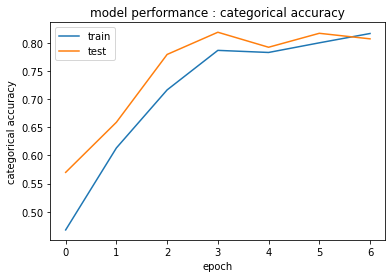

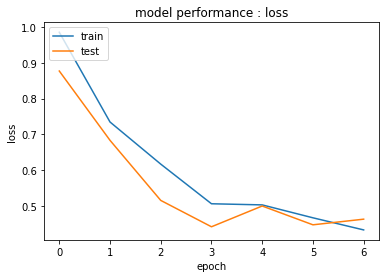

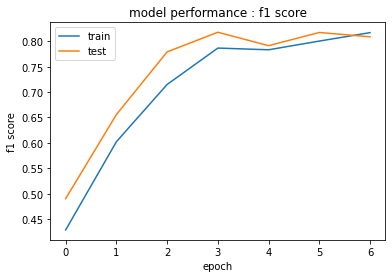

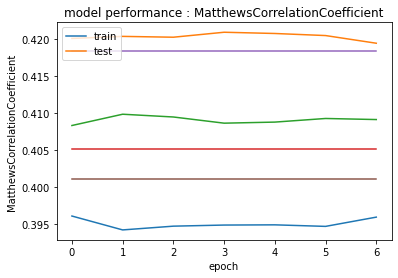

In [22]:
plot_model_history(train_history, ['categorical_accuracy', 'loss', 'f1_score', 'MatthewsCorrelationCoefficient'])

In [ ]:
train_history.history

### Save Model Weights

In [33]:
#def touch_dir(dirname):
#    if not os.path.exists(dirname):
#        os.makedirs(dirname)
#        print(f"Created directory {dirname}.")
#    else:
#        print(f"Directory {dirname} already exists.")


def save_model(model, transformer_dir='.'):
    """
    Special function to load a keras model that uses a transformer layer
    """
    import pickle
    transformer = model.layers[1]
    #touch_dir(transformer_dir)
    transformer.save_pretrained(transformer_dir)
    softmax = model.get_layer('softmax').get_weights()
    pickle.dump(softmax, open('softmax.pickle', 'wb'))

def load_model(transformer_dir='.', max_len=256):
    """
    Special function to load a keras model that uses a transformer layer
    """
    transformer = TFAutoModel.from_pretrained(transformer_dir)
    model = build_model(transformer, max_len=max_len)
    softmax = pickle.load(open('softmax.pickle', 'rb'))
    model.get_layer('softmax').set_weights(softmax)

    return model

In [34]:
save_model(model, transformer_dir='.')

In [37]:
from IPython.display import FileLink
FileLink('./tf_model.h5')

/kaggle/working/tf_model.h5